Import our packages that we need immediately- add others along the way

In [1]:
import pandas as pd
from alpaca_trade_api.rest import REST
import matplotlib.pyplot as plt
import numpy as np

Using Alpacas as the source for data- provides most up to date

In [2]:
api = REST("PK9CDN3AL1QK6G9URIZJ", "yRg7cpobg8sMnH0sv7eCISFb6b5QN8bcGDiyA0N6", base_url="https://data.alpaca.markets")

Choosing ticker and start and end date

In [3]:
bars = api.get_bars(
    "MSFT",
    timeframe="5Min",
    start="2025-03-01",
    end="2025-08-02"
).df

# Convert index from UTC to US Eastern Time
bars.index = bars.index.tz_convert('US/Eastern')

bars = bars.between_time('09:30', '16:00')

# Filter out weekends (keep Monday=0 to Friday=4)
bars = bars[bars.index.dayofweek < 5]

print(bars.tail())

                             close     high     low  trade_count    open  \
timestamp                                                                  
2025-08-01 15:40:00-04:00  524.160  524.365  523.66         5779  523.74   
2025-08-01 15:45:00-04:00  525.055  525.110  523.93         8484  524.20   
2025-08-01 15:50:00-04:00  524.570  526.260  523.79        13297  525.07   
2025-08-01 15:55:00-04:00  524.000  524.870  523.62        29061  524.54   
2025-08-01 16:00:00-04:00  524.190  524.480  523.93          564  524.00   

                            volume        vwap  
timestamp                                       
2025-08-01 15:40:00-04:00   216190  524.115982  
2025-08-01 15:45:00-04:00   304286  524.547844  
2025-08-01 15:50:00-04:00   471077  524.625114  
2025-08-01 15:55:00-04:00  1443689  524.264365  
2025-08-01 16:00:00-04:00  4206277  524.109882  


Setting up our df to call what we want

In [4]:
msft = bars['close']

print(msft.tail())

timestamp
2025-08-01 15:40:00-04:00    524.160
2025-08-01 15:45:00-04:00    525.055
2025-08-01 15:50:00-04:00    524.570
2025-08-01 15:55:00-04:00    524.000
2025-08-01 16:00:00-04:00    524.190
Name: close, dtype: float64


Plotting stock prices

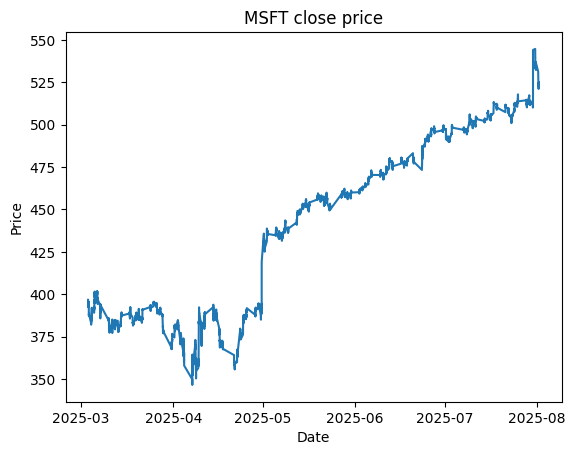

In [5]:
plt.plot(msft)
plt.title('MSFT close price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Kernel Density of stock prices

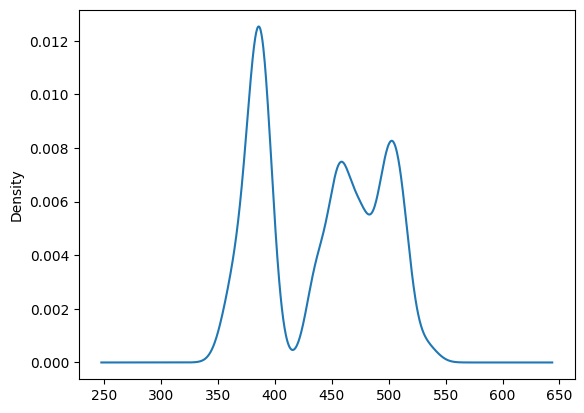

In [6]:
msft.plot(kind='kde')
plt.show()

Dickey Fuller test- stock prices are non stationary

In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(msft.dropna())
print('ADF Stat:', result[0])
print('p-value:', result[1])

ADF Stat: -0.16336804089097626
p-value: 0.9427495111013021


Seperating trend and seasonality

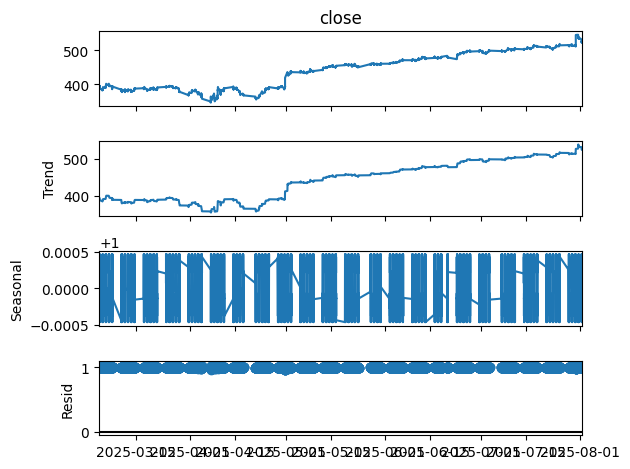

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(msft, model='multiplicative', period = 30)
result.plot()
plt.show()

We take the log of the series to reduce the magnitude of values and reduce the trend of our series. After the log, we will find the rolling average. A rolling average is done for a set period.

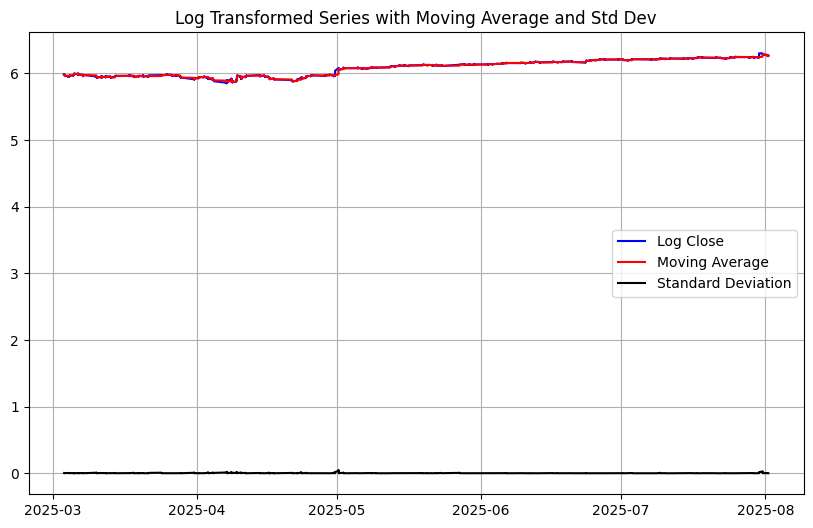

In [9]:
plt.rcParams['figure.figsize'] = (10,6)

msft_log = np.log(msft)

moving_avg = msft_log.rolling(12).mean()
std_dev = msft_log.rolling(12).std()

plt.plot(msft_log, color='blue', label='Log Close')
plt.plot(moving_avg, color="red", label="Moving Average")
plt.plot(std_dev, color="black", label="Standard Deviation")

plt.title('Log Transformed Series with Moving Average and Std Dev')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Now- create ARIMA model and train on closing price on train data- so split and visualise

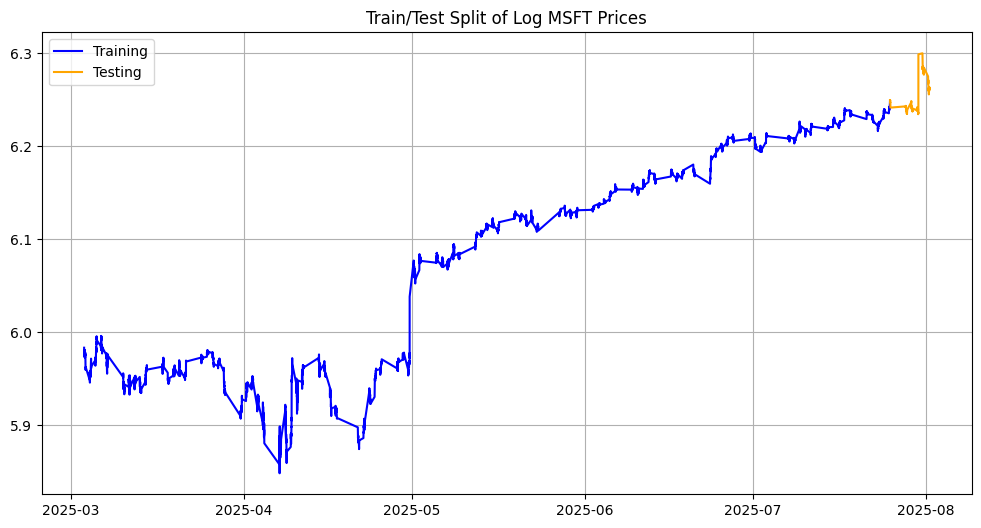

In [10]:
split_idx = int(len(msft_log) * 0.95)

train = msft_log.iloc[:split_idx] #rows in X%
test = msft_log.iloc[split_idx:] #rows in 1-X%

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training', color='blue')
plt.plot(test, label='Testing', color='orange')
plt.legend()
plt.title('Train/Test Split of Log MSFT Prices')
plt.grid(True)
plt.show()

Need to choose the parameters for our ARIMA- we can do this using the auto ARIMA which will run all the possible models and find the best one based off criteria such as BIC and AIC.

/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-pack

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-76097.524, Time=0.39 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-76112.394, Time=0.49 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-76113.381, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76097.356, Time=0.15 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-76112.313, Time=1.25 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-76116.978, Time=0.50 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-76113.348, Time=1.00 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-76115.599, Time=0.67 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-76113.127, Time=0.90 sec


/Users/nickking/PycharmProjects/Beginning/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-76116.901, Time=0.42 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 6.388 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7951
Model:               SARIMAX(0, 1, 2)   Log Likelihood               38062.489
Date:                Sun, 03 Aug 2025   AIC                         -76116.978
Time:                        14:52:21   BIC                         -76089.055
Sample:                             0   HQIC                        -76107.417
                               - 7951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.355e-05   2.52e-05      1.329      0.184   -1.59e-0

<function matplotlib.pyplot.show(close=None, block=None)>

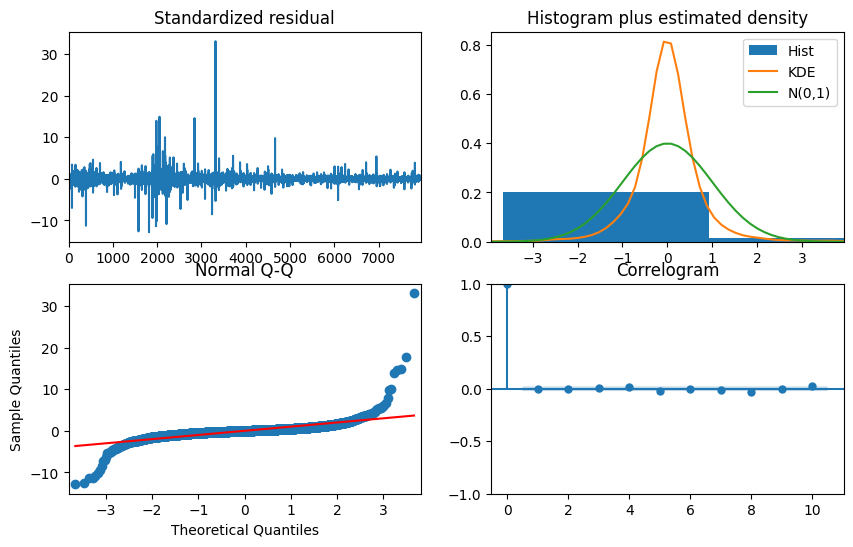

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                             test='adf',
                             max_p=3, max_q=3,
                             m=1,
                             d=None,
                             seasonal=False,
                             startP=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics()
plt.show


Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

The model provide (0,1,2) as the best fit so lets model this

In [18]:
train.index = pd.to_datetime(train.index)
train = train.asfreq('5min')

# Resample test to continuous 5-minute freq and fill missing values
test.index = pd.to_datetime(test.index)
test_continuous = test.asfreq('5min')
test_continuous = test_continuous.fillna(method='ffill')  # or .interpolate()

model = ARIMA(train, order=(0,1,2))
fitted = model.fit()

print(fitted.summary())

/var/folders/1m/k225dj3x4yz7mpfywd8kznt80000gn/T/ipykernel_75226/3171860371.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_continuous = test_continuous.fillna(method='ffill')  # or .interpolate()


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                41515
Model:                 ARIMA(0, 1, 2)   Log Likelihood               39243.344
Date:                Sun, 03 Aug 2025   AIC                         -78480.688
Time:                        14:55:52   BIC                         -78454.787
Sample:                    03-03-2025   HQIC                        -78472.504
                         - 07-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0584      0.005    -11.896      0.000      -0.068      -0.049
ma.L2          0.0031      0.003      0.894      0.372      -0.004       0.010
sigma2      2.806e-06   4.29e-09    654.092      0.0

Now forecasting

In [19]:
forecast_obj = fitted.get_forecast(steps=len(test_continuous))

fc = forecast_obj.predicted_mean
conf = forecast_obj.conf_int(alpha=0.05)


print("Forecast length:", len(fc))
print("Test length:", len(test))
print("Forecast index start:", fc.index[0])
print("Forecast index end:", fc.index[-1])
print("Test index start:", test.index[0])
print("Test index end:", test.index[-1])


Forecast length: 2040
Test length: 419
Forecast index start: 2025-07-25 14:05:00-04:00
Forecast index end: 2025-08-01 16:00:00-04:00
Test index start: 2025-07-25 14:05:00-04:00
Test index end: 2025-08-01 16:00:00-04:00


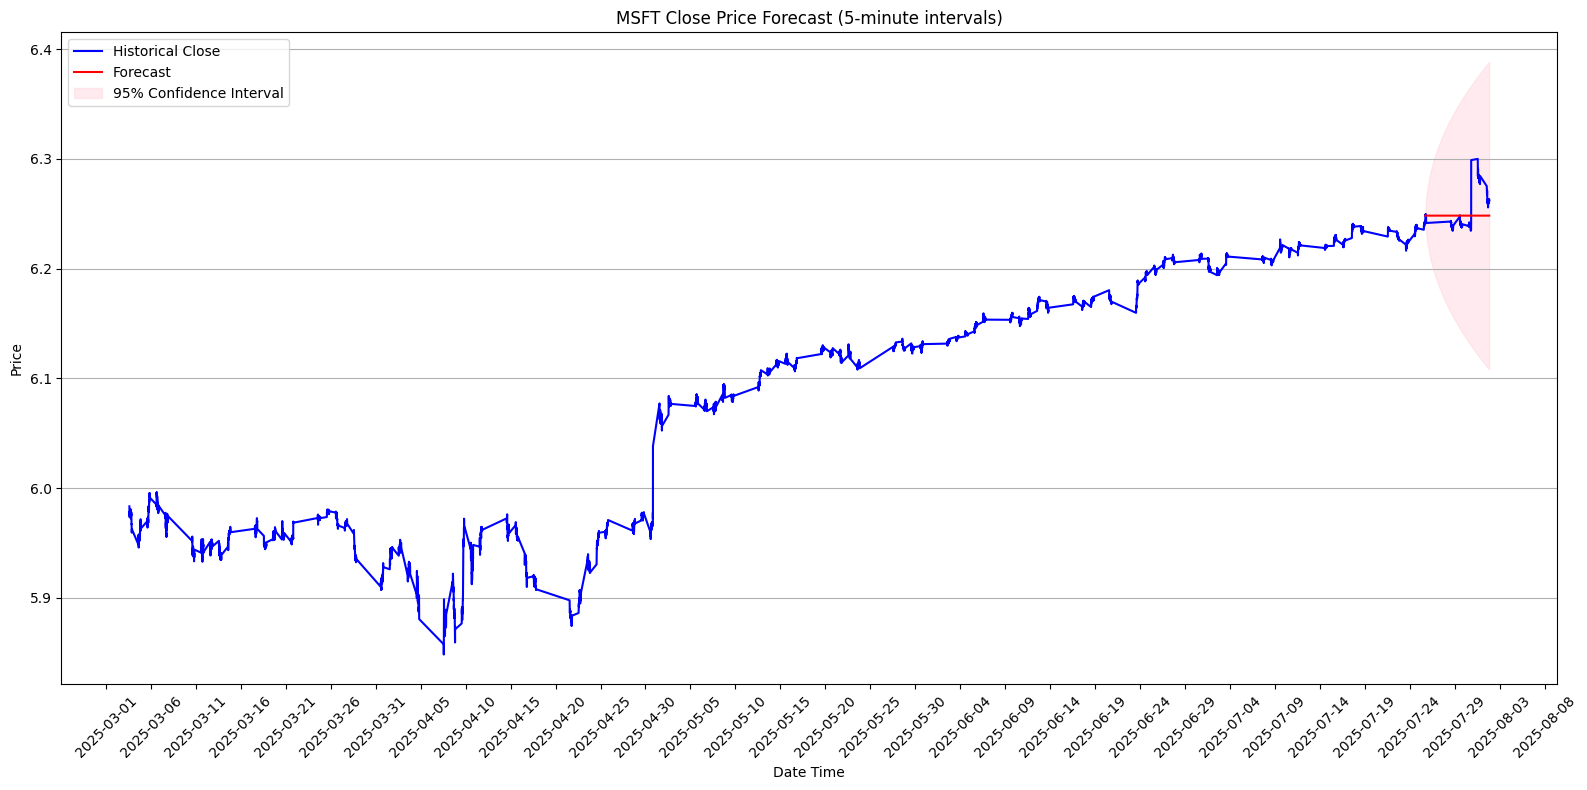

In [24]:
import matplotlib.dates as mdates

plt.figure(figsize=(16,8))
plt.plot(msft.index, msft_log, label='Historical Close', color='blue')
plt.plot(fc.index, fc, label='Forecast', color='red')
plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('MSFT Close Price Forecast (5-minute intervals)')
plt.xlabel('Date Time')
plt.ylabel('Price')

# Show ticks every 5 trading days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
